# Transfer Learning Model

Setup

In [35]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt




In [36]:
# Set the path to the data directory
data_address = os.path.join(os.getcwd(),'..', 'Data')
image_address = os.path.join(data_address, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
training_label = pd.read_csv(os.path.join(data_address, 'training_label.csv'))
testing_label = pd.read_csv(os.path.join(data_address, 'testing_label.csv'))


In [37]:
# Get the image paths
train_images_normal = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Normal'].X_ray_image_name.tolist()]
train_images_sick = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]
test_images_normal = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Normal'].X_ray_image_name.tolist()]
test_images_sick = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]


In [38]:
# Function for plotting images
plots_dir = "../plots"
os.makedirs(plots_dir,exist_ok=True)
#plot accuracy curves
def plot_fig(i, history, model):
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,epochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,epochs])
    plt.grid(True)
    plt.title("Model Accuracy" + str(model))
    plt.show()
    fig.savefig(os.path.join(plots_dir, str(i)+'-accuracy.jpg'))
    plt.close(fig)

Preprocess Data

In [39]:
# modeling parameters
train_arrays = []
size = (256, 256)
batch_size = 32

In [40]:
# Create an ImageDataGenerator and do Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,        # Degree range for random rotations
    width_shift_range=0.2,    # Range for horizontal shift
    height_shift_range=0.2,   # Range for vertical shift
    shear_range=0.2,          # Shear intensity range
    zoom_range=0.2,           # Range for random zoom
    horizontal_flip=True,     # Randomly flip images horizontally
    vertical_flip=False       # Do not flip images vertically
)


In [41]:
# Load the training data
training_label.dropna()
for x in training_label['X_ray_image_name']:
    try:
        img_path = os.path.join(image_address, 'train', x)
        img = image.load_img(img_path, target_size=size)
        img_array = image.img_to_array(img)
        train_arrays.append(img_array)
    except Exception as e:
        print(f"Error loading image: {img_path}")
        # Handle the exception or skip the image if necessary

In [42]:
# Convert train_arrays and label to NumPy arrays
train_images = np.array(train_arrays)
label_mapping = {"Pnemonia": 1, "Normal": 0}
label = training_label['Label'].map(label_mapping)
train_images = train_images.astype('float32') / 255.0


In [43]:
# Split the data into training and validation sets
augmented_images = datagen.flow(train_images, label, batch_size=batch_size)
augmented_train_images = []
augmented_labels = []

for images, labels in augmented_images:
    augmented_train_images.append(images)
    augmented_labels.append(labels)
    if len(augmented_train_images) >= len(train_images) / batch_size):
        break

augmented_train_images = np.concatenate(augmented_train_images)
augmented_labels = np.concatenate(augmented_labels)


In [44]:
# Split the data into training and validation sets
train_images = np.concatenate((train_images, augmented_train_images))
labels = np.concatenate((label, augmented_labels))

train_images, val_images, train_labels, val_labels = train_test_split(train_images, labels, test_size=0.2, random_state=42)
final_train_images, val_images, final_train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)



# Modeling

ResNet Model

In [45]:
# Define the input size
epochs = 2
batch_size = 32
input_shape = (256, 256, 3)
num_classes = 2
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
validation_data = (val_images, val_labels)


In [54]:
# Build the ResNet model
base_model = tf.keras.applications.ResNet50(input_shape=input_shape,
                                            include_top=False,
                                            weights='imagenet')
base_model.trainable = False

# Add custom head to the base model
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

validation_data = (val_images, val_labels)
history_resnet = model.fit(final_train_images, final_train_labels, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_15  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_44 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_45 (Dense)            (None, 2)                 1026      
                                                          

Text(0.5, 1.0, 'Loss Curves')

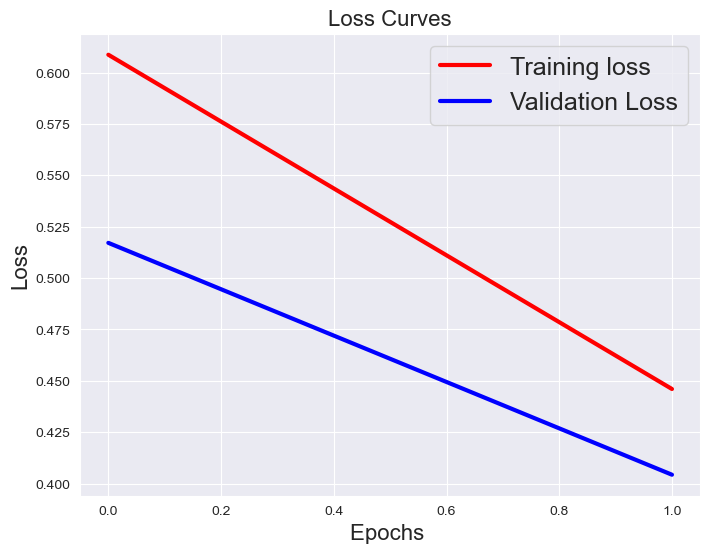

In [47]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_resnet.history['loss'],'r',linewidth=3.0)
plt.plot(history_resnet.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

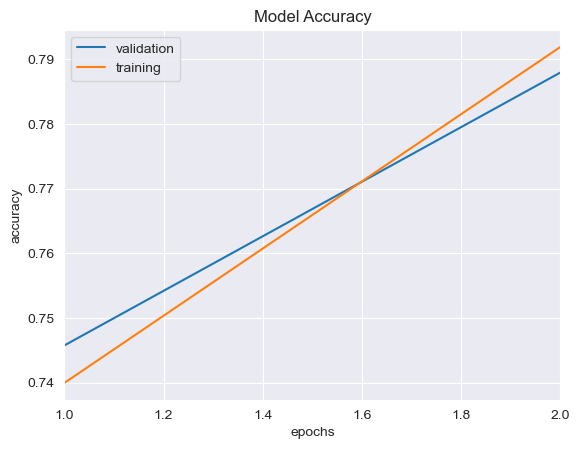

In [48]:
# plot accuracy
plot_fig(1, history_resnet, 'ResNet')

## VGG

In [55]:

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# validation set
final_train_labels_encoded = to_categorical(final_train_labels, num_classes=2)
val_labels_encoded = to_categorical(val_labels, num_classes=2)
validation_data = (val_images, val_labels_encoded)

# Train the model with data
history_vgg = model.fit(final_train_images, final_train_labels_encoded, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])



Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0  

Text(0.5, 1.0, 'Loss Curves')

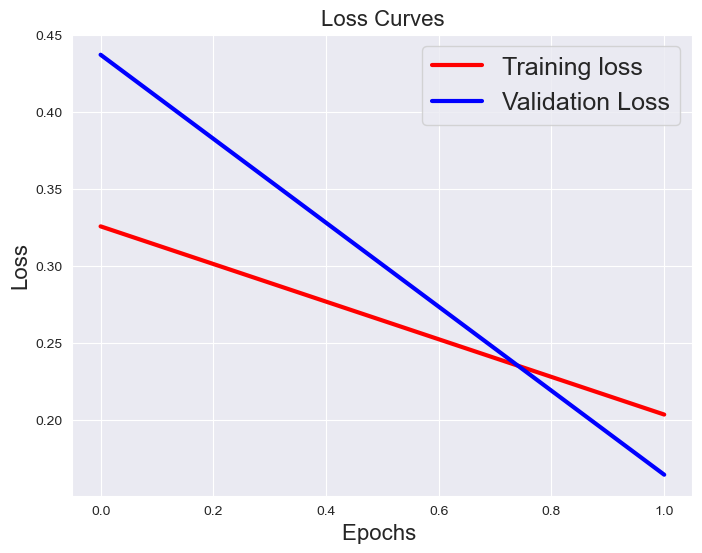

In [60]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_vgg.history['loss'],'r',linewidth=3.0)
plt.plot(history_vgg.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

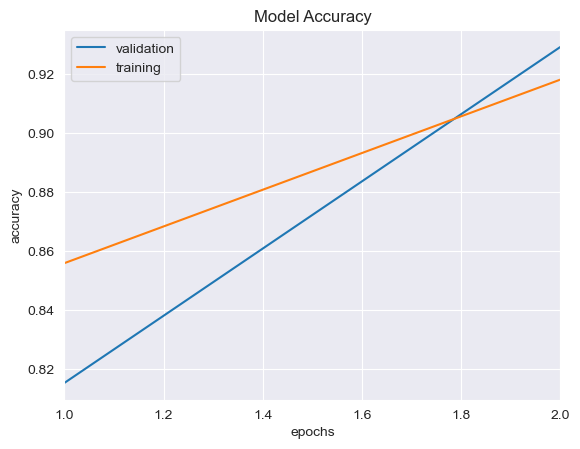

In [59]:
# plot accuracy
plot_fig(1, history_vgg, 'VGG')

EfficientNet Model

In [56]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data
# validation set
final_train_labels_encoded = to_categorical(final_train_labels, num_classes=2)
val_labels_encoded = to_categorical(val_labels, num_classes=2)
validation_data = (val_images, val_labels_encoded)
history_en = model.fit(final_train_images, final_train_labels_encoded, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 256, 256, 3)  0           ['input_20[0][0]']               
                                                                                                  
 normalization_2 (Normalization  (None, 256, 256, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                           

Text(0.5, 1.0, 'Loss Curves')

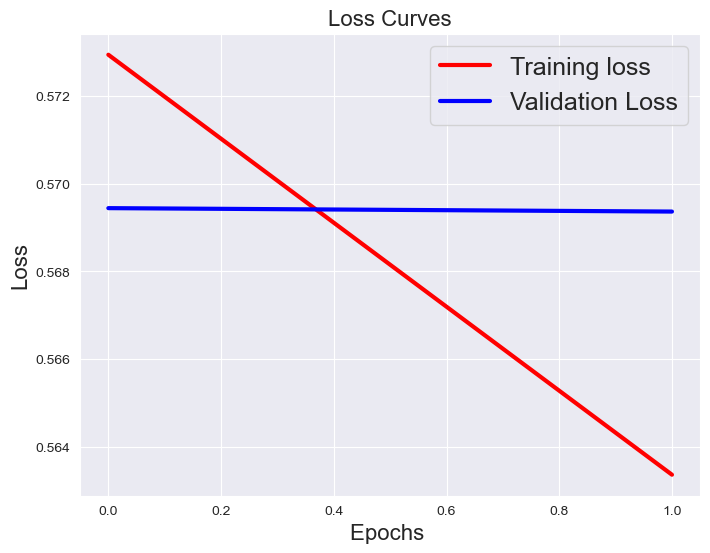

In [57]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_en.history['loss'],'r',linewidth=3.0)
plt.plot(history_en.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

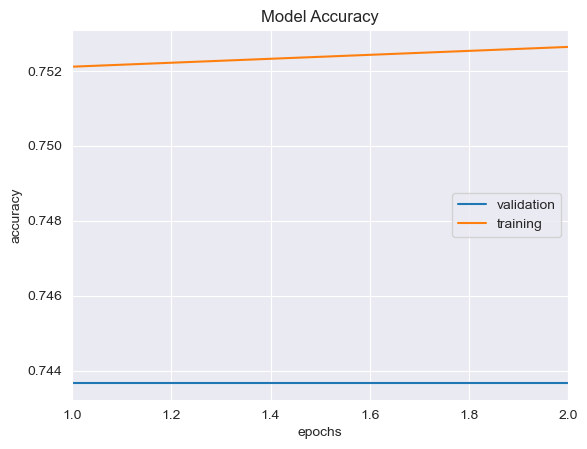

In [58]:
# plot accuracy
plot_fig(1, history_en, 'EfficientNet')

DenseNet Model

In [61]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add a custom head to the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# validation set
final_train_labels_encoded = to_categorical(final_train_labels, num_classes=2)
val_labels_encoded = to_categorical(val_labels, num_classes=2)
validation_data = (val_images, val_labels_encoded)
# Train the model with data
history_dn = model.fit(final_train_images, final_train_labels_encoded, batch_size=batch_size, epochs=epochs, validation_data=validation_data, callbacks=[callbacks])


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 262, 262, 3)  0          ['input_21[0][0]']               
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                          

Text(0.5, 1.0, 'Loss Curves')

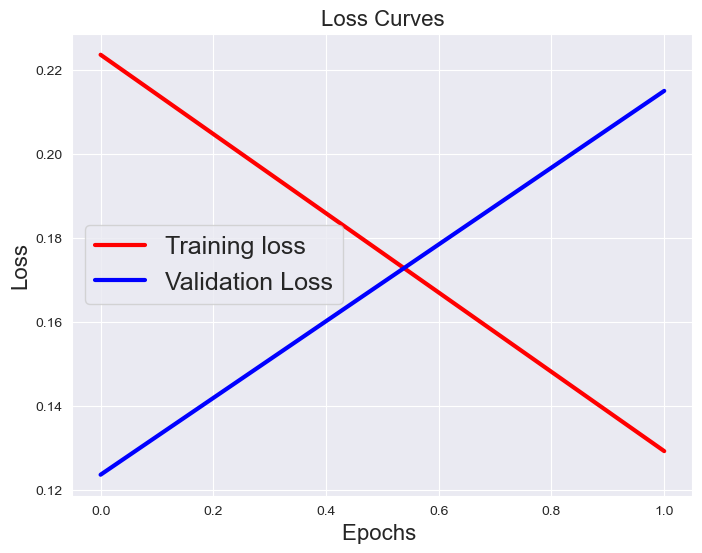

In [62]:
# plot loss curves
plt.figure(figsize=[8,6])
plt.plot(history_dn.history['loss'],'r',linewidth=3.0)
plt.plot(history_dn.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

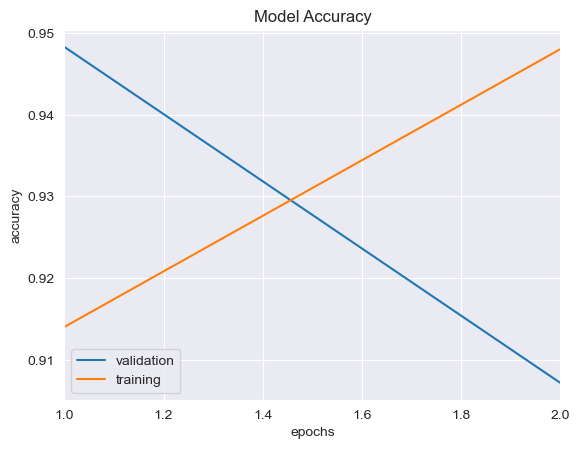

In [63]:
# plot accuracy
plot_fig(1, history_dn, 'DenseNet')